# Covid-19 CT 3D Image Segmentation with [MEDICAI](https://github.com/innat/medic-ai)

This tutorials shows how to use [medicai](https://github.com/innat/medic-ai), a [keras](https://keras.io/) based multi-backend medical image processing library to solve **Covid-19 CT** scans. 

**Dataset**: The `.nii` format CT scans can be found [here](https://www.kaggle.com/datasets/ipythonx/covid-19-ct-seg-20cases). We have converted the raw format to tfrecord format. The format process can be found [here](https://www.kaggle.com/code/ipythonx/generate-3d-nii-to-tfrecord-dataset). The converted tfrecord dataset can be found [here](https://www.kaggle.com/datasets/ipythonx/covid19-20case-tfrecord). The dataset consist of 3 classes, i.e. left lung, right lung and infected areas. In this notebook, we've treated it as multi-class segmentation task.

**Model**: We will be using [**SwinUNETR**](https://arxiv.org/abs/2201.01266) from `medicai`. 

In [1]:
import os, sys
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt

import cv2
import imageio
import IPython.display as display

In [2]:
os.environ["KERAS_BACKEND"] = "tensorflow" # tensorflow, torch, jax

from medicai.utils.general import hide_warnings
hide_warnings()

import keras
import tensorflow as tf

from medicai.transforms import (
    Compose,
    ScaleIntensityRange,
    CropForeground,
    RandCropByPosNegLabel,
    Spacing,
    Orientation,
    RandShiftIntensity,
    RandRotate90,
    RandFlip
)

keras.config.set_dtype_policy("mixed_float16")
keras.backend.backend(), keras.__version__, tf.__version__

E0000 00:00:1744823402.980307   22683 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744823402.986864   22683 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744823403.003772   22683 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744823403.003792   22683 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744823403.003795   22683 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744823403.003797   22683 computation_placer.cc:177] computation placer already registered. Please check linka

('tensorflow', '3.9.0', '2.19.0')

# Transformation

- For preprocessing, we will be using data scaling, cropping, orientation, and spacing.
- For augmentation, we will be using random crop, randm flip, random rotate, and random shift intensity.

**Note:** Each sample expects to process single sample to process and shape of the sample should be `depth, height, width, channel` format.

In [3]:
def rearrange_shape(sample):
    image = sample['image']
    label = sample['label']
    affine = sample['affine']

    # special case
    image = tf.transpose(image, perm=[2, 1, 0, 3])  # hwdc -> dhwc
    label = tf.transpose(label, perm=[2, 1, 0, 3])  # hwdc -> dhwc
    cols = tf.gather(affine, [2, 1, 0], axis=1)  # (whd) -> (dhw)
    affine = tf.concat([cols, affine[:, 3:]], axis=1)

    # re-update sample with new / updated tensor
    sample['image'] = image
    sample['label'] = label
    sample['affine'] = affine
    return sample


def train_transformation(sample):
    meta = {"affine": sample["affine"]}
    data = {"image": sample["image"], "label": sample["label"]}
    pipeline = Compose([
        ScaleIntensityRange(
            keys=["image"],
            a_min=-175,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True
        ),
        CropForeground(
            keys=("image", "label"),
            source_key="image"
        ),
        Orientation(keys = ("image", "label"), axcodes = "RAS"),
        Spacing(pixdim=(2.0, 1.5, 1.5), keys=["image", "label"]),
        RandCropByPosNegLabel(
            keys=("image", "label"),
            spatial_size=[96, 96, 96], 
            pos=1, 
            neg=1, 
            num_samples=1
        ),
        RandFlip(keys=["image", "label"], spatial_axis=[0], prob=0.1),
        RandFlip(keys=["image", "label"], spatial_axis=[1], prob=0.1),
        RandFlip(keys=["image", "label"], spatial_axis=[2], prob=0.1),
        RandRotate90(keys=["image", "label"], prob=0.1, max_k=3, spatial_axes=(0, 1)),
        RandShiftIntensity(keys=["image"], offsets=0.10, prob=0.50)
    ])
    result = pipeline(data, meta)
    return result["image"], result["label"]


def val_transformation(sample):
    meta = {"affine": sample["affine"]}
    data = {"image": sample["image"], "label": sample["label"]}
    pipeline = Compose([
        ScaleIntensityRange(
            keys=["image"],
            a_min=-175,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True
        ),
        CropForeground(
            keys=("image", "label"),
            source_key="image"
        ),
        Orientation(keys = ("image", "label"), axcodes = "RAS"),
        Spacing(pixdim=(2.0, 1.5, 1.5), keys=["image", "label"])
    ])
    result = pipeline(data, meta)
    return result["image"], result["label"]

# Dataloader

We have converted `.nii` file to `tfrecord` format. Please check [here](https://www.kaggle.com/code/ipythonx/generate-3d-nii-to-tfrecord-dataset) about how it's done.

In [4]:
def parse_tfrecord_fn(example_proto):
    feature_description = {
        "image_raw": tf.io.FixedLenFeature([], tf.string),
        "label_raw": tf.io.FixedLenFeature([], tf.string),
        "image_shape": tf.io.FixedLenFeature([3], tf.int64),
        "label_shape": tf.io.FixedLenFeature([3], tf.int64),
        "image_affine": tf.io.FixedLenFeature([16], tf.float32),
        "label_affine": tf.io.FixedLenFeature([16], tf.float32),
        "image_pixdim": tf.io.FixedLenFeature([8], tf.float32),
        "label_pixdim": tf.io.FixedLenFeature([8], tf.float32),
    }
    
    example = tf.io.parse_single_example(example_proto, feature_description)
    
    # Decode image and label data
    image = tf.io.decode_raw(example["image_raw"], tf.float32)
    label = tf.io.decode_raw(example["label_raw"], tf.float32)
    
    # Reshape to original dimensions
    image = tf.reshape(image, example["image_shape"])
    label = tf.reshape(label, example["label_shape"])
    image = image[..., None] # hwd -> hwdc
    label = label[..., None] # hwd -> hwdc
    
    # Decode affine matrices
    image_affine = tf.squeeze(tf.reshape(example["image_affine"], (4, 4)))
    label_affine = tf.squeeze(tf.reshape(example["label_affine"], (4, 4)))

    # Decode voxel spacing (pixdim)
    image_pixdim = example["image_pixdim"]
    label_pixdim = example["label_pixdim"]

    return {
        "image": image,
        "label": label,
        "affine": image_affine, # Since image and label affine are the same
    }

In [5]:
def load_tfrecord_dataset(tfrecord_pattern, batch_size=1, shuffle=True):
    dataset = tf.data.TFRecordDataset(tf.io.gfile.glob(tfrecord_pattern))
    dataset = dataset.shuffle(buffer_size=50) if shuffle else dataset
    dataset = dataset.map(parse_tfrecord_fn, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(rearrange_shape, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        dataset = dataset.map(train_transformation, num_parallel_calls=tf.data.AUTOTUNE)
    else:
        dataset = dataset.map(val_transformation, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

In [6]:
tfrecord_pattern = "covid19/1/tfrecords/{}_shard_*.tfrec"

train_ds = load_tfrecord_dataset(
    tfrecord_pattern.format("training"), batch_size=1, shuffle=True
)
val_ds = load_tfrecord_dataset(
    tfrecord_pattern.format("validation"), batch_size=1, shuffle=False
)

I0000 00:00:1744823408.897869   22683 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13764 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5


**visualize**

In [7]:
x, y = next(iter(val_ds))
test_image = x.numpy().squeeze()
test_mask = y.numpy().squeeze()
test_image.shape, test_mask.shape, np.unique(test_mask)

((117, 287, 287), (117, 287, 287), array([0., 1., 2., 3.], dtype=float32))

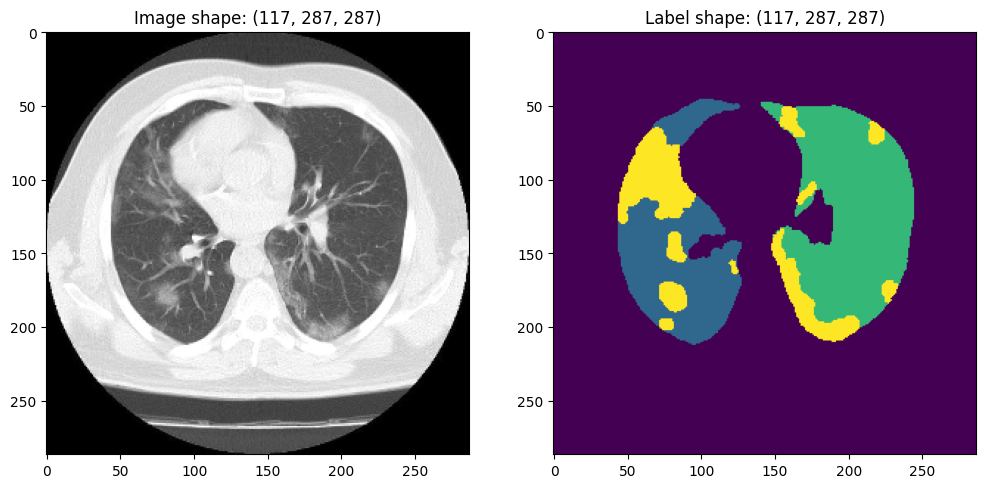

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(test_image[test_image.shape[0]//2], cmap='gray')
ax1.set_title(f'Image shape: {test_image.shape}')
ax2.imshow(test_mask[test_mask.shape[0]//2])
ax2.set_title(f'Label shape: {test_mask.shape}')
plt.show()

# Model

In [9]:
from medicai.models import SwinUNETR
from medicai.metrics import SparseDiceMetric
from medicai.losses import SparseDiceCELoss

num_classes = 4
input_shape = (96, 96, 96, 1)

model = SwinUNETR(
    input_shape=input_shape, 
    num_classes=num_classes,
    classifier_activation=None
)

model.compile(
    optimizer=keras.optimizers.AdamW(
        learning_rate=1e-4,
        weight_decay=1e-5,
    ),
    loss=SparseDiceCELoss(
        from_logits=True,
        num_classes=num_classes,
    ),
    metrics=[
        SparseDiceMetric(
            from_logits=True,
            ignore_empty=True,
            num_classes=num_classes,
            name='dice',
        )
    ],
    jit_compile=False,
)

model.count_params() / 1e6

62.186806

## Inference Callback

The `medicai` provides `SlidingWindowInferenceCallback` in order to run large volume sample inference effectively.

In [10]:
from medicai.callbacks import SlidingWindowInferenceCallback

swi_callback_metric = SparseDiceMetric(
    from_logits=True,
    ignore_empty=True,
    num_classes=num_classes,
    name='dice'
)

swi_callback = SlidingWindowInferenceCallback(
    model,
    dataset=val_ds, 
    metrics=swi_callback_metric,
    num_classes=num_classes,
    interval=100,
    overlap=0.8,
    roi_size=(96, 96, 96),
    sw_batch_size=4,
    save_path="covid19.model.weights.h5"
)

# Training

Set more epochs for better results.

In [ ]:
history = model.fit(
    train_ds, 
    epochs=500,
    callbacks=[
        swi_callback
    ]
)

Epoch 1/500


I0000 00:00:1744823466.590135   22851 cuda_dnn.cc:529] Loaded cuDNN version 90300


18/18 ━━━━━━━━━━━━━━━━━━━━ 167s 785ms/step - dice: 0.2145 - loss: 2.3266
Epoch 2/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - dice: 0.3088 - loss: 1.5523
Epoch 3/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 34s 728ms/step - dice: 0.3317 - loss: 1.4180
Epoch 4/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - dice: 0.3102 - loss: 1.4122
Epoch 5/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 33s 724ms/step - dice: 0.3071 - loss: 1.4241
Epoch 6/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - dice: 0.3281 - loss: 1.3929
Epoch 7/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 34s 717ms/step - dice: 0.3847 - loss: 1.3124
Epoch 8/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 34s 733ms/step - dice: 0.3825 - loss: 1.2900
Epoch 9/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 27s 819ms/step - dice: 0.3921 - loss: 1.3218
Epoch 10/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - dice: 0.4471 - loss: 1.2114
Epoch 11/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 32s 914ms/step - dice: 0.3530 - loss: 1.3181
Epoch 12/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 28s 750ms/step - dice: 0.4467 - loss: 1.2547
Epoch 13/500

IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


18/18 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - dice: 0.5770 - loss: 1.0127
Epoch 39/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 31s 901ms/step - dice: 0.5277 - loss: 1.1023
Epoch 40/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 29s 801ms/step - dice: 0.4533 - loss: 1.0327
Epoch 41/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - dice: 0.5552 - loss: 1.0231
Epoch 42/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 28s 755ms/step - dice: 0.4511 - loss: 1.0644
Epoch 43/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 29s 863ms/step - dice: 0.5016 - loss: 0.9637
Epoch 44/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - dice: 0.5579 - loss: 0.9562
Epoch 45/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 28s 732ms/step - dice: 0.5739 - loss: 0.9663
Epoch 46/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 28s 917ms/step - dice: 0.5634 - loss: 0.9901
Epoch 47/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 27s 718ms/step - dice: 0.5145 - loss: 0.9259
Epoch 48/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 28s 738ms/step - dice: 0.5579 - loss: 0.9193
Epoch 49/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 27s 794ms/step - dice: 0.5675 - loss: 1.0145
Ep

Total patch 576: 100%|██████████| 144/144 [02:28<00:00,  1.03s/it]


Epoch 100: Score = 0.6214
New best score! Model saved to covid19.model.weights.h5
18/18 ━━━━━━━━━━━━━━━━━━━━ 321s 18s/step - dice: 0.5998 - loss: 0.8569
Epoch 101/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 28s 787ms/step - dice: 0.5874 - loss: 0.8226
Epoch 102/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 29s 868ms/step - dice: 0.5840 - loss: 0.8288
Epoch 103/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 29s 797ms/step - dice: 0.5653 - loss: 0.8280
Epoch 104/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 30s 720ms/step - dice: 0.5237 - loss: 0.8518
Epoch 105/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 29s 801ms/step - dice: 0.6343 - loss: 0.8165
Epoch 106/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 28s 949ms/step - dice: 0.6930 - loss: 0.8633
Epoch 107/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 29s 914ms/step - dice: 0.6099 - loss: 0.8624
Epoch 108/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 26s 793ms/step - dice: 0.7247 - loss: 0.8445
Epoch 109/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 27s 753ms/step - dice: 0.6121 - loss: 0.7750
Epoch 110/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - dice: 0.6238 - los

Total patch 576: 100%|██████████| 144/144 [02:28<00:00,  1.03s/it]


Epoch 200: Score = 0.6320
New best score! Model saved to covid19.model.weights.h5
18/18 ━━━━━━━━━━━━━━━━━━━━ 304s 17s/step - dice: 0.6490 - loss: 0.9045
Epoch 201/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 27s 818ms/step - dice: 0.6025 - loss: 0.8568
Epoch 202/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - dice: 0.6098 - loss: 0.7639
Epoch 203/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - dice: 0.6632 - loss: 0.7520
Epoch 204/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 28s 748ms/step - dice: 0.6654 - loss: 0.8262
Epoch 205/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 27s 756ms/step - dice: 0.6779 - loss: 0.7980
Epoch 206/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - dice: 0.7327 - loss: 0.7624
Epoch 207/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 29s 796ms/step - dice: 0.7276 - loss: 0.8040
Epoch 208/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 30s 935ms/step - dice: 0.6802 - loss: 0.7789
Epoch 209/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 29s 810ms/step - dice: 0.7251 - loss: 0.7567
Epoch 210/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - dice: 0.7558 - loss: 0.7398

Total patch 576: 100%|██████████| 144/144 [02:28<00:00,  1.03s/it]


Epoch 300: Score = 0.7952
New best score! Model saved to covid19.model.weights.h5
18/18 ━━━━━━━━━━━━━━━━━━━━ 299s 17s/step - dice: 0.7778 - loss: 0.7229
Epoch 301/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - dice: 0.7689 - loss: 0.7906
Epoch 302/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 29s 862ms/step - dice: 0.7844 - loss: 0.6083
Epoch 303/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 30s 891ms/step - dice: 0.7042 - loss: 0.8062
Epoch 304/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - dice: 0.8187 - loss: 0.7064
Epoch 305/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 29s 993ms/step - dice: 0.7033 - loss: 0.6955
Epoch 306/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 31s 921ms/step - dice: 0.7084 - loss: 0.7380
Epoch 307/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - dice: 0.7467 - loss: 0.7104
Epoch 308/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 29s 772ms/step - dice: 0.7974 - loss: 0.6034
Epoch 309/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - dice: 0.7458 - loss: 0.7342
Epoch 310/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - dice: 0.7311 - loss: 0.6802
Ep

Total patch 576: 100%|██████████| 144/144 [02:29<00:00,  1.03s/it]


Epoch 400: Score = 0.8653
New best score! Model saved to covid19.model.weights.h5
18/18 ━━━━━━━━━━━━━━━━━━━━ 299s 17s/step - dice: 0.8828 - loss: 0.5440
Epoch 401/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - dice: 0.8441 - loss: 0.6761
Epoch 402/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 29s 803ms/step - dice: 0.6868 - loss: 0.6727
Epoch 403/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - dice: 0.8226 - loss: 0.5827
Epoch 404/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 26s 782ms/step - dice: 0.7987 - loss: 0.6313
Epoch 405/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 27s 900ms/step - dice: 0.7017 - loss: 0.6849
Epoch 406/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 30s 987ms/step - dice: 0.8321 - loss: 0.6021
Epoch 407/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 30s 809ms/step - dice: 0.8016 - loss: 0.6707
Epoch 408/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 29s 950ms/step - dice: 0.8430 - loss: 0.6162
Epoch 409/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 27s 977ms/step - dice: 0.8245 - loss: 0.6511
Epoch 410/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 27s 903ms/step - dice: 0.7552 - loss: 

Total patch 576: 100%|██████████| 144/144 [02:28<00:00,  1.03s/it]


Epoch 500: Score = 0.8046
18/18 ━━━━━━━━━━━━━━━━━━━━ 291s 16s/step - dice: 0.8111 - loss: 0.6302


In [ ]:
print(model.history.history.keys())
his_csv = pd.DataFrame(model.history.history)
his_csv.to_csv('history.csv')
his_csv.head()

dict_keys(['dice', 'loss'])


,dice,loss
0,0.272230,1.992891
1,0.315110,1.516072
2,0.326116,1.464053
3,0.321471,1.401754
4,0.296285,1.419275


# Evaluation

We can evaluate the model per-class or on average.

In [13]:
from medicai.utils.inference import SlidingWindowInference

model.load_weights(
    'covid19.model.weights.h5'
)
swi = SlidingWindowInference(
    model,
    num_classes=num_classes,
    roi_size=(96, 96, 96),
    sw_batch_size=4,
    overlap=0.8,
)

In [15]:
num_classes

4

In [18]:
from keras import ops

dice = SparseDiceMetric(
    from_logits=True,
    ignore_empty=True,
    num_classes=num_classes,
    name='dice',
)
dice_lungs = SparseDiceMetric(
    from_logits=True,
    ignore_empty=True,
    num_classes=num_classes,
    class_ids=[1,2], # left+right lungs
    name='dice_lungs'
)
dice_infection = SparseDiceMetric(
    from_logits=True,
    ignore_empty=True,
    num_classes=num_classes,
    class_ids=[3], # infected areas
    name='dice_infection'
)

In [19]:
for sample in val_ds:
    x, y = sample
    output = swi(x)
    
    y = ops.convert_to_tensor(y)
    output = ops.convert_to_tensor(output)
    
    dice.update_state(y, output)
    dice_lungs.update_state(y, output)
    dice_infection.update_state(y, output)

dice_score = float(ops.convert_to_numpy(dice.result()))
dice_score_lungs = float(ops.convert_to_numpy(dice_lungs.result()))
dice_score_infection = float(ops.convert_to_numpy(dice_infection.result()))

print(f"Dice Score: {dice_score:.4f}")
print(f"Dice Score on lungs: {dice_score_lungs:.4f}")
print(f"Dice Score on infections: {dice_score_infection:.4f}")

dice.reset_states()
dice_lungs.reset_states()
dice_infection.reset_states()

Total patch 576: 100%|██████████| 144/144 [02:31<00:00,  1.05s/it]


Dice Score: 0.8653
Dice Score on lungs: 0.8500
Dice Score on infections: 0.7685


# Visualize

In [43]:
x, y = next(iter(val_ds))
x.shape, y.shape, np.unique(y.numpy())

(TensorShape([1, 117, 287, 287, 1]),
 TensorShape([1, 117, 287, 287, 1]),
 array([0., 1., 2., 3.], dtype=float32))

In [44]:
y_pred = swi(x)
y_pred = y_pred.argmax(-1)
y_pred.shape

Total patch 432: 100%|██████████| 108/108 [01:51<00:00,  1.03s/it]


(1, 117, 287, 287)

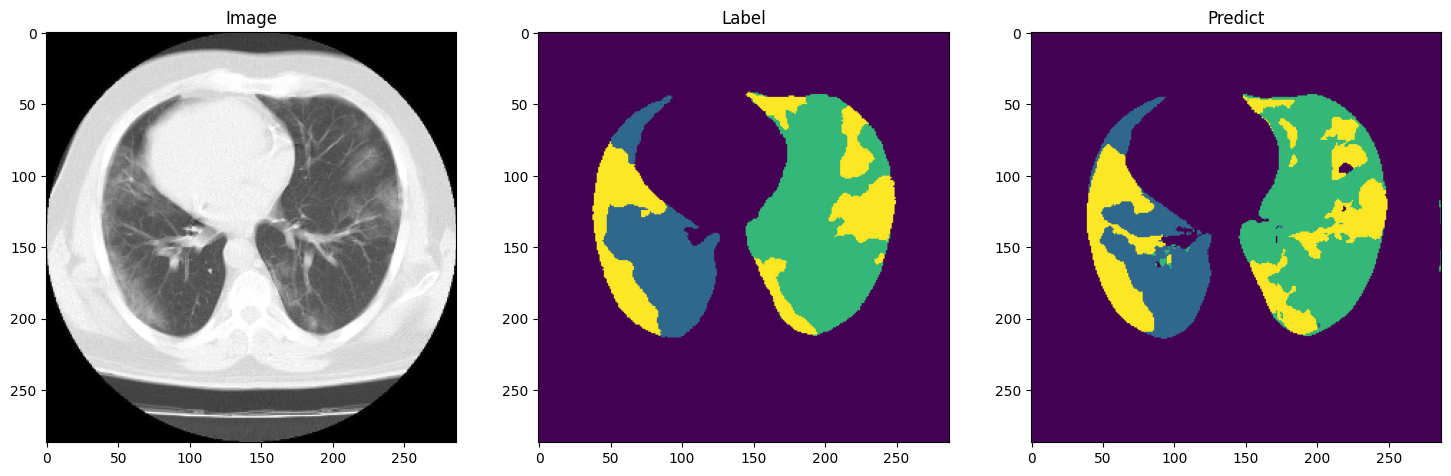

In [56]:
slice_num=50
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
ax1.imshow(x.numpy()[0, slice_num, :, :, 0], cmap="gray")
ax1.set_title('Image')
ax2.imshow(y.numpy()[0, slice_num, :, :, 0])
ax2.set_title('Label')
ax3.imshow(y_pred[0, slice_num, :, :])
ax3.set_title('Predict')
plt.show()

**Overlay**

In [47]:
a = x.numpy().squeeze()
b = y.numpy().astype(np.uint8).squeeze()
c = y_pred.squeeze().astype(np.uint8) 
print(a.shape, a.dtype, b.shape, b.dtype, c.shape, c.dtype)

(117, 287, 287) float32 (117, 287, 287) uint8 (117, 287, 287) uint8


In [48]:
colormap = {
    0: [0, 0, 0],        # background (black/transparent)
    85: [101, 0, 185],   # Left lung 1 (red in RGB)
    170: [80, 200, 0],   # Left lung 2 (green in RGB)
    255: [255, 255, 0]   # Infections (yellow in BGR)
}

a_min, a_max = -175, 250 
b_min, b_max = 0.0, 1.0 
a = (((a - b_min) / (b_max - b_min)) * (a_max - a_min) + a_min).astype(np.uint8)
b = (b * (255 / b.max())).astype(np.uint8)
c = (c * (255 / c.max())).astype(np.uint8)
print(a.shape, a.dtype, b.shape, b.dtype, c.shape, c.dtype)

(117, 287, 287) uint8 (117, 287, 287) uint8 (117, 287, 287) uint8


In [49]:
frames = []
for i in range(a.shape[0]):
    img = cv2.cvtColor(a[i], cv2.COLOR_GRAY2RGB)
    mask = c[i].copy()
    
    colored_mask = np.zeros((*mask.shape, 3), dtype=np.uint8)
    for value, color in colormap.items():
        colored_mask[mask == value] = color
    
    mask_zero = mask == 0
    colored_mask[mask_zero, :] = [0, 0, 0]
    
    overlay = cv2.addWeighted(img, 1.0, colored_mask, 0.3, 0)
    frames.append(overlay)

imageio.mimsave("pred_mask.gif", frames, duration=0.3, fps=10, loop=0)

In [1]:
with open("pred_mask.gif", "rb") as f:
    display.display(
        display.Image(data=f.read(), format="png")
    )